In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG
import os
import pydotplus

import keras
from keras import regularizers
from keras.optimizers import Adam, SGD, rmsprop
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout, Input, Dropout, concatenate
from keras.layers.recurrent import GRU, LSTM
from keras.utils import plot_model
# keras.utils.vis_utils.pydot = pydot
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = np.load("drive/My Drive/imputed-normed-ep_1_24_raw.npz", allow_pickle=True)

In [4]:
lst = data.files
for item in lst:
    print(item)
#     print(data[item])
data["ep_data"].shape

ep_data
ep_tdata
ep_data_masking
ep_tdata_masking
y_icd9
y_mor
adm_features_all
adm_labels_all
y_los


(36093, 360)

In [5]:
data["ep_tdata"].shape

(36093, 24, 15)

In [6]:
data['adm_features_all'].shape

(36093, 5)

In [7]:
data["adm_labels_all"].shape

(36093, 6)

In [0]:
features_sequence = data['ep_tdata'].astype(np.float32) # 15 time series features
features_static = data['adm_features_all'].astype(np.float32) # 5 non-ts features,the unit of age: day
labels = data["adm_labels_all"][:, 2].astype(np.float32) # 48hrs or In-hospital  mortality, change here

In [0]:
# transpose the features_sequence
trans = [0]*features_sequence.shape[0]

In [0]:
for i in range(features_sequence.shape[0]):
    trans[i] = features_sequence[i].T

In [0]:
trans= np.array(trans)

In [41]:
trans.shape

(36093, 15, 24)

In [0]:
features_sequence = trans

In [0]:
# split the whole dataset
x_seq_full_train, x_seq_test, x_static_full_train, x_static_test, y_full_train, y_test = train_test_split(
    features_sequence, features_static, labels, test_size = 0.20, random_state = 202)

x_seq_train, x_seq_val, x_static_train, x_static_val, y_train, y_val = train_test_split(
    x_seq_full_train, x_static_full_train, y_full_train, test_size = 0.20, random_state = 202)

In [44]:
x_seq_train.shape

(23099, 15, 24)

In [45]:
# Count the positive labels
count = 0
for i in range(y_train.shape[0]):
    if y_train[i] == 1:
        count += 1
count

426

In [0]:
# upsampling
x_seq_up = []
x_static_up = []
y_up = []
for i in range(x_seq_train.shape[0]):
    count = 0
    if y_train[i] == 1:
        while count < 5:
            x_seq_up.append(x_seq_train[i])
            x_static_up.append(x_static_train[i])
            y_up.append(y_train[i])
            count += 1

In [47]:
print(len(x_seq_up), len(x_static_up), len(y_up))

2130 2130 2130


In [0]:
a = np.concatenate((x_seq_train, x_seq_up))
b = np.concatenate((x_static_train, x_static_up))
c = np.concatenate((y_train, y_up))

In [0]:
index = list(range(len(c)))
np.random.shuffle(index)

In [0]:
x_seq_train = []
x_static_train = []
y_train = []

for i in index:
    x_seq_train.append(a[i])
    x_static_train.append(b[i])
    y_train.append(c[i])

In [51]:
print(len(x_seq_train), len(x_static_train), len(y_train))

25229 25229 25229


In [0]:
x_seq_train  = np.array(x_seq_train)
x_static_train = np.array(x_static_train)
y_train = np.array(y_train)

In [53]:
print(x_seq_train.shape, x_static_train.shape, y_train.shape)

(25229, 15, 24) (25229, 5) (25229,)


In [0]:
# impute the missing values in the dataset with the mean

def impute_mean(source_data, input_data):
    '''
    Takes the source data, and uses it to determine means for all
    features; it then applies them to the input data.
    
    inputs:
    source_data: a tensor to provide means
    input_data: the data to fill in NA for
    
    output:
    output_data: data with nans imputed for each feature
    
    '''
    
    output_data = input_data.copy()
    
    for feature in range(source_data.shape[1]):
        feature_mean = np.nanmean(source_data[:, feature, :][np.where(source_data[:, feature, :] != 0)])
        ind_output_data = np.where(np.isnan(output_data[:, feature, :]))
        output_data[:, feature, :][ind_output_data] =  feature_mean
    return output_data

In [0]:
x_seq_train_original = x_seq_train.copy()
x_seq_train = impute_mean(x_seq_train_original, x_seq_train)
x_seq_val = impute_mean(x_seq_train_original, x_seq_val)
x_seq_test = impute_mean(x_seq_train_original, x_seq_test)

In [56]:
# Define inputs
sequence_input = Input(shape = (x_seq_train.shape[1], x_seq_train.shape[2], ), dtype = 'float32', name = 'sequence_input')
static_input = Input(shape = (x_static_train.shape[1], ), name = 'static_input')

# Network architecture
seq_x = GRU(units = 128, )(sequence_input)
# seq_x = Dense(64, input_dim=128, kernel_regularizer=regularizers.l2(0.1))(seq_x) #Regularizer
# Seperate output for the GRU later
seq_aux_output = Dense(1, activation='sigmoid', name='aux_output')(seq_x)

# Merge dual inputs
x = concatenate([seq_x, static_input])

# We stack a deep fully-connected network on the merged inputs
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
# Sigmoid output layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

# optimizer
opt = Adam(lr = 0.0001)

# build model
model = Model(inputs = [sequence_input, static_input], outputs = [main_output, seq_aux_output])
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'], loss_weights = [1, 0.1])

# save a plot of the model
#plot_model(model, to_file='experiment_GRU-DO.svg')

# fit the model
history = model.fit([x_seq_train, x_static_train], [y_train, y_train], epochs = 80, batch_size = 128,\
                    validation_data=([x_seq_val, x_static_val], [y_val, y_val]),)

Train on 25229 samples, validate on 5775 samples
Epoch 1/80
25229/25229 [==============================] - 8s 311us/step - loss: 25.0120 - main_output_loss: 24.9162 - aux_output_loss: 0.3335 - main_output_accuracy: 0.8010 - aux_output_accuracy: 0.8986 - val_loss: 1.0764 - val_main_output_loss: 1.0417 - val_aux_output_loss: 0.1425 - val_main_output_accuracy: 0.9827 - val_aux_output_accuracy: 0.9827
Epoch 2/80
25229/25229 [==============================] - 7s 285us/step - loss: 9.5687 - main_output_loss: 9.5237 - aux_output_loss: 0.3158 - main_output_accuracy: 0.8026 - aux_output_accuracy: 0.8987 - val_loss: 0.3473 - val_main_output_loss: 0.3275 - val_aux_output_loss: 0.1335 - val_main_output_accuracy: 0.9827 - val_aux_output_accuracy: 0.9827
Epoch 3/80
25229/25229 [==============================] - 7s 291us/step - loss: 6.5119 - main_output_loss: 6.4824 - aux_output_loss: 0.3121 - main_output_accuracy: 0.8001 - aux_output_accuracy: 0.8986 - val_loss: 0.2561 - val_main_output_loss: 0.238

In [0]:
# Define inputs
sequence_input = Input(shape = (x_seq_train.shape[1], x_seq_train.shape[2], ), dtype = 'float32', name = 'sequence_input')
static_input = Input(shape = (x_static_train.shape[1], ), name = 'static_input')

# Network architecture
seq_x = GRU(units = 128, )(sequence_input)
# seq_x = Dense(64, input_dim=128, kernel_regularizer=regularizers.l2(0.1))(seq_x) #Regularizer
# Seperate output for the GRU later
seq_aux_output = Dense(1, activation='sigmoid', name='aux_output')(seq_x)

# Merge dual inputs
x = concatenate([seq_x, static_input])

# We stack a deep fully-connected network on the merged inputs
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
# Sigmoid output layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

# optimizer
opt = Adam(lr = 0.0001)

# build model
model = Model(inputs = [sequence_input, static_input], outputs = [main_output, seq_aux_output])
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'], loss_weights = [1, 0.1])

# save a plot of the model
#plot_model(model, to_file='experiment_GRU-DO.svg')

# fit the model
history = model.fit([x_seq_train, x_static_train], [y_train, y_train], epochs = 80, batch_size = 128,\
                    validation_data=([x_seq_val, x_static_val], [y_val, y_val]),)

Train on 36224 samples, validate on 5775 samples
Epoch 1/80
36224/36224 [==============================] - 11s 297us/step - loss: 48.2287 - main_output_loss: 48.1615 - aux_output_loss: 0.6714 - main_output_accuracy: 0.5004 - aux_output_accuracy: 0.5820 - val_loss: 0.8590 - val_main_output_loss: 0.7917 - val_aux_output_loss: 0.5606 - val_main_output_accuracy: 0.8878 - val_aux_output_accuracy: 0.8784
Epoch 2/80
36224/36224 [==============================] - 10s 282us/step - loss: 14.6127 - main_output_loss: 14.5478 - aux_output_loss: 0.6497 - main_output_accuracy: 0.5036 - aux_output_accuracy: 0.6126 - val_loss: 13.1779 - val_main_output_loss: 13.0943 - val_aux_output_loss: 0.5556 - val_main_output_accuracy: 0.1122 - val_aux_output_accuracy: 0.8426
Epoch 3/80
36224/36224 [==============================] - 10s 283us/step - loss: 8.2942 - main_output_loss: 8.2304 - aux_output_loss: 0.6381 - main_output_accuracy: 0.5104 - aux_output_accuracy: 0.6310 - val_loss: 2.5985 - val_main_output_loss

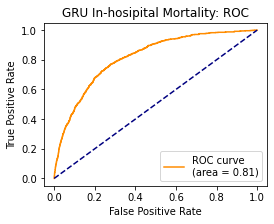

In [0]:
# Round 1
# AUC for in-hospital mortality prediction
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

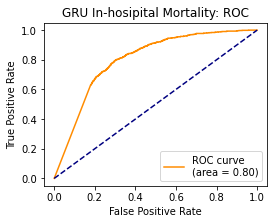

In [0]:
# Round 1
# AUC for in-hospital mortality prediction
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

In [36]:
#auprc
from sklearn.metrics import average_precision_score
average_precision1 = average_precision_score(y_test, pred_aux)
average_precision2 = average_precision_score(y_test, pred_main)
average_precision1, average_precision2

(0.3422039460691303, 0.33490009739243776)

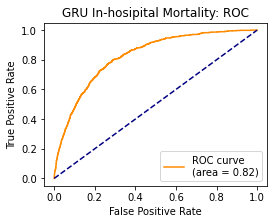

In [0]:
# Round 2
# AUC for in-hospital mortality prediction
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

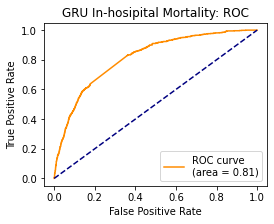

In [0]:
# Round 2
# AUC for in-hospital mortality prediction
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')

plt.show()

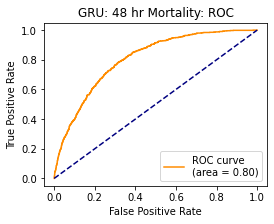

In [0]:
# AUC for 48 hrs mortality
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU: 48 hr Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

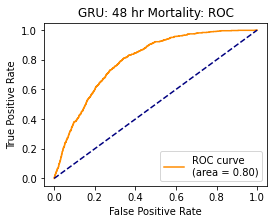

In [0]:
# AUC for 48 hrs mortality
# the difference of pred_main and pred_aux is that pred_main uses both time series data and non-ts data, but pred_aux only uses the time series data to do prediction

pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU: 48 hr Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

In [57]:
#auprc
from sklearn.metrics import average_precision_score
average_precision1 = average_precision_score(y_test, pred_aux)
average_precision2 = average_precision_score(y_test, pred_main)
average_precision1, average_precision2

(0.07935763240061343, 0.08524032832221069)

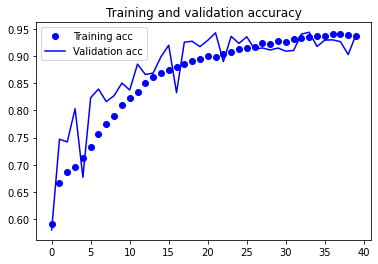

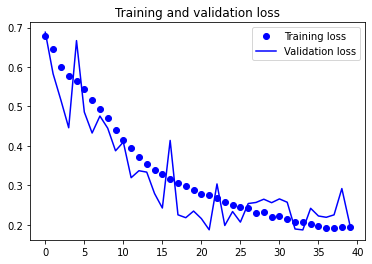

In [0]:
# 48 hrs mortality prediction
# plot training and validation loss and accuracy

acc = history.history['aux_output_accuracy']
val_acc = history.history['val_aux_output_accuracy']
loss = history.history['aux_output_loss']
val_loss = history.history['val_aux_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

fig_name = 'loss_svg.svg'
fig.savefig('loss_svg.svg', bbox_inches='tight')

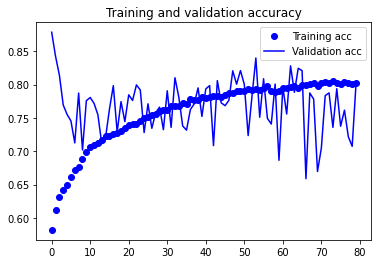

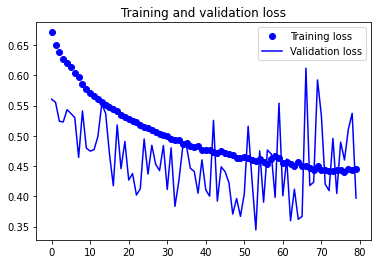

In [0]:
# in-hospital mortality prediction
# plot training and validation loss and accuracy

acc = history.history['aux_output_accuracy']
val_acc = history.history['val_aux_output_accuracy']
loss = history.history['aux_output_loss']
val_loss = history.history['val_aux_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

fig_name = 'loss_svg.svg'
fig.savefig('loss_svg.svg', bbox_inches='tight')

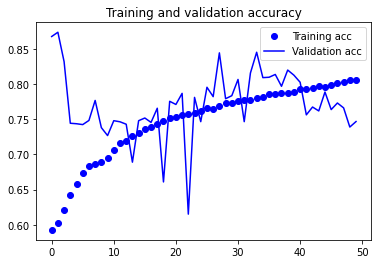

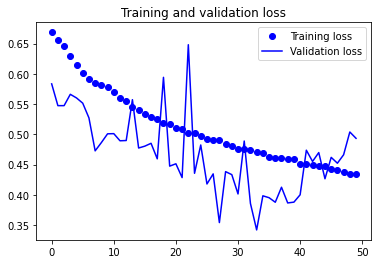

In [0]:
# in-hospital mortality prediction
# plot training and validation loss and accuracy

acc = history.history['aux_output_accuracy']
val_acc = history.history['val_aux_output_accuracy']
loss = history.history['aux_output_loss']
val_loss = history.history['val_aux_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

fig_name = 'loss_svg.svg'
fig.savefig('loss_svg.svg', bbox_inches='tight')